# Non-Stationary K-Armed Bandits

On the previous notebook, we saw how we can obtain pretty good results on a stationary problem by incrementally updating our expected action-values using a sample average technique. This means that for every new reward we observe, we weight all our both previous and new experience equally, and add them together to determine the new average value. This works great on situations where the value of each action doesn't change over time (aka. stationary), but when this doesn't hold, then averaging doesn't make sense anymore.

For non-stationary problems, past experience should start to be valued less than our current knowledge. That is because what we found out on the past may no longer hold true, as the value of each action could be changing over time. For this, we can change our update rule of our agent, so that it no longer equally weights all knowledge, but instead exponentially decay past knowledge. This can easily be done by changing our update weight `1/n` to a static value `a` which is between 0 and 1

## Implementing the situation

We're going to reuse most of the code we already built on the previous notebook. The only things we're adding is a parameter `a` for our agent, and making our bandits non-stationary, by adding a small random value to each arm whenever it gets pulled.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First let's make our bandits non-stationary

In [5]:
class Bandit:
    def __init__(self, k, batchsize=1, walkstdev=0, mean=0, stdev=1):
        self.k = k
        self.batchsize = batchsize
        self.arms_mean = stdev*np.random.randn(batchsize,k) + mean
        self.walkstdev = walkstdev
        
    def pull(self, idx):
        outcomes = np.random.randn(self.batchsize) + self.arms_mean[np.arange(self.batchsize),idx]
        self.arms_mean += self.walkstdev*np.random.randn(self.batchsize,self.k) # make arms non-stationary. Add random walks with stddev of 0.01
        return outcomes
    
    def optimal(self):
        return np.argmax(self.arms_mean, axis=1)

Let's see how our arms expected value changes every time we pull the levers

In [9]:
b = Bandit(5, 1, 0.01)
print(b.arms_mean)
b.pull(1)
print(b.arms_mean)

[[ 0.16694302 -0.01040594 -1.03117007  0.63551813  1.85567661]]
[[ 0.15769301  0.00400869 -1.03458796  0.61555983  1.85882856]]


Notice that after we pulled down the lever, the expected value of each arm has changed a little.

Now comes the Agent. For this, we're going to be adding a new parameter called `a` or learning paramter. This paramter will be defined as a function that receives the array `n` or the number of times the choses arms have been pulled for all experiments. This implementation allows us to test different values for a, that could or not be related by the prior experience. This will be useful later.

In [20]:
def incrementalAverage(n):
    return 1/n

class Agent:
    def __init__(self, k, timesteps, batchsize=1, epsilon=0, a=None, expected=None):
        self.k = k
        self.batchsize = batchsize
        self.n = np.zeros((batchsize, k)).astype(int) # Number of elapsed time-steps for each action. Will be updated every time we decide to update our expected rewards for each arm
        self.log = np.zeros((timesteps, 2, batchsize)) # Store the total obtained reward as an array of entries. This will allow us to see how much reward it obtained over time
        self.current_time = 0
        self.epsilon = epsilon
        if a is None:
            a = averageValue
        self.a = a
        if expected is None:
            expected = np.zeros((batchsize, k)) # Default to zeros of size k
        assert list(expected.shape) == [batchsize,k], 'Expected values must have the same shape as the number of expected arms and batch size'
        self.expected = np.array(expected)
        
        
    def choose_action(self):
        # Return the index of the next arm to pull. This is done using argmax with probability 1-epsilon, and choosing randomly with probability epsilon
        
        # Define which type of desicion to take for each experiment. 1 means greedy action and 0 means random action
        choice_type = (np.random.random_sample((self.batchsize)) > self.epsilon).astype(int)
        
        random_actions = np.random.randint(self.k, size=self.batchsize)
        greedy_actions = np.argmax(self.expected + 0.1*np.random.random(self.expected.shape), axis=1)
        
        # Since the type of actions are mutually exclusive, we can add the combination of both actions
        return greedy_actions * choice_type + random_actions * (1 - choice_type)
        
    def update(self, action, reward):
        # Receives an action index to be updated and the amount of reward seen on the elapsed time-step
        self.n[np.arange(self.batchsize), action] += 1
        self.log[self.current_time] = np.array([[action, reward]])
        self.current_time += 1
        
        n = self.n[np.arange(self.batchsize), action]
        self.expected[np.arange(self.batchsize), action] += self.a(n)*(reward - self.expected[np.arange(self.batchsize), action])
        return self.expected
    

We also implemented the function `incrementalAverage` which behaves as a default `a` that basically makes our agent work just as before: an average-value agent

### Experiments and testing

Let's see how our stationary agent behaves in a non-stationary scenario

In [35]:
def exponentialDecay(n):
    # Use a static value as our learning parameter. Results in exponentail decay of past experience
    return 0.11

def experiment(k, experiments, timesteps, epsilon=0, nonstationarity=0, a=None, initial_expectation=None):
    a = Agent(k, timesteps, experiments, epsilon, a, initial_expectation)
    b = Bandit(k, experiments, nonstationarity)
    print("running experiment")
    for _ in range(timesteps):
        action = a.choose_action()
        reward = b.pull(action)
        a.update(action, reward)
        
    print("Done!")
    
    # plot the log in terms of how many times the optimal action was chosen
    actions_log = a.log[:,0]
    optimal = b.optimal()
    correct = (actions_log == optimal).astype(int)
    correct_percent = np.mean(correct, axis=1)
    return correct_percent
    

running experiment
Done!


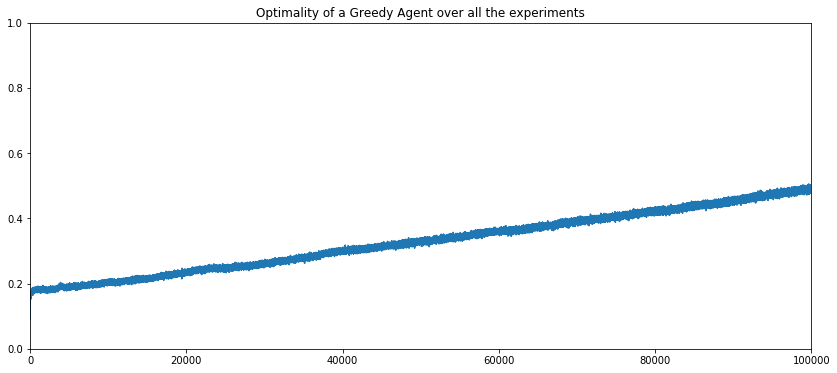

In [39]:
k = 10
experiments = 2000
timesteps = 100000

stationary_results = experiment(k, experiments, timesteps, 0.1, 0.01)
plt.figure(figsize=(14,6))
plt.title('Optimality of a Greedy Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=stationary_results)

As we can see, our agent didn't behave as great as it did on a stationary scenario. This most probably is because there is no such thing as a static optimal action in this situation. At any time, our optimal action could change because our environment is no longer static. Let's see now how an agent that exponentially decays it's past experience would behave on this scenario

running experiment
Done!


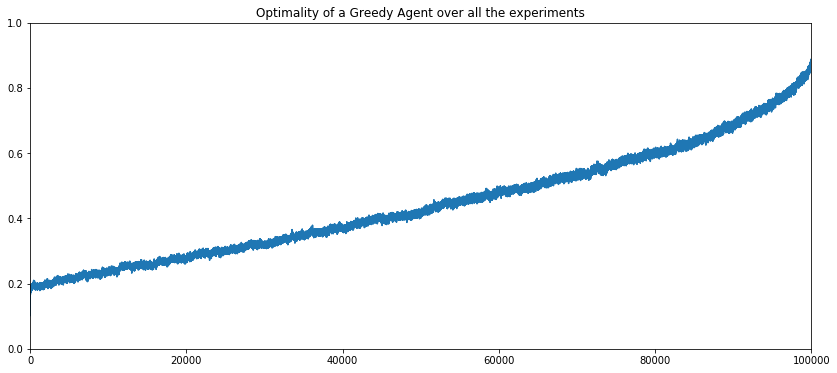

In [40]:
nonstationary_results = experiment(k, experiments, timesteps, 0.1, 0.01, exponentialDecay)
plt.figure(figsize=(14,6))
plt.title('Optimality of a Greedy Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=nonstationary_results)

As we can see, our agent is capable of finding the optimal action over time, even if that optimal value changes stochastically. Let's compare both performances

[Text(0, 0.5, 'Optimality percentage'), Text(0.5, 0, 'Time Steps')]

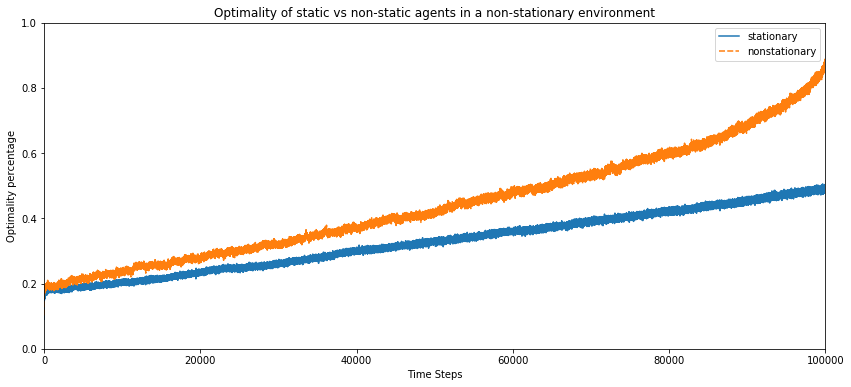

In [41]:
results_df = pd.DataFrame({
    'stationary': stationary_results, 
    'nonstationary': nonstationary_results, 
})

plt.figure(figsize=(14,6))
plt.title('Optimality of static vs non-static agents in a non-stationary environment')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
ax = sns.lineplot(hue='event', style='event',data = results_df)
ax.set(xlabel='Time Steps', ylabel='Optimality percentage')

As can be seen, a constant StepSize parameter has an overall better performance on non-stationary problems, as they are capable of adapting to changes on the environment by caring less and less about past experience. Our sample-average agent couldn't perform better than a greedy agent on a stationary scenario.